In [1]:
%load_ext load_style
%load_style talk.css

# Read SST data, Create and Save nino3 time series

In this notebook, we will finish these tasks
* subsample SST data over the nino3 area
* calcualte climatology
* calculate anomalies
* calculate regional mean
* plot regional mean SST time series
* save data

## 1. Load basic libraries

In [2]:
%matplotlib inline
import numpy as np
from numpy import nonzero

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
import matplotlib.dates as mdates

import datetime             
from netCDF4 import Dataset # http://unidata.github.io/netcdf4-python/
from netCDF4 import netcdftime
from netcdftime import utime

## 2. Set and read input NetCDF file info

### 2.1 Read data

In [3]:
ncfile = 'data\skt.mon.mean.nc'

fh     = Dataset(ncfile, mode='r') # file handle, open in read only mode
lon    = fh.variables['lon'][:]
lat    = fh.variables['lat'][:]
nctime = fh.variables['time'][:]
t_unit = fh.variables['time'].units
skt    = fh.variables['skt'][:]

try :
    t_cal = fh.variables['time'].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

fh.close() # close the file

### 2.2 Parse time

In [4]:
utime = netcdftime.utime(t_unit, calendar = t_cal)
datevar = utime.num2date(nctime)
print(datevar.shape)

datevar[0:5]

(687L,)


array([datetime.datetime(1948, 1, 1, 0, 0),
       datetime.datetime(1948, 2, 1, 0, 0),
       datetime.datetime(1948, 3, 1, 0, 0),
       datetime.datetime(1948, 4, 1, 0, 0),
       datetime.datetime(1948, 5, 1, 0, 0)], dtype=object)

## 3. Subregion for nino3 area

* Lat: -5 ~ 5
* Lon: 210 ~ 270

### 3.1 Get indices of time, lat and lon over the nino3 area

In [5]:
idx_lat_n3  = (lat>=-5.0) * (lat<=5.0)
idx_lon_n3  = (lon>=210.0) * (lon<=270.0)

* time: 1970-1999

In [6]:
years = np.array([idx.year for idx in datevar])
idx_tim_n3 = (years>=1970) * (years<=1999)

Get Index using np.nonzero

In [7]:
idxtim = nonzero(idx_tim_n3)[0]
#idxlat = nonzero(idx_lat_n3)[0]
idxlon = nonzero(idx_lon_n3)[0]
idxlon

array([112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144], dtype=int64)

### 3.2 Extract data over nino3 area

Use logical indexing is fine for 1D array; however, a little funny for multiple dimension array.

In [8]:
lat_n3 = lat[idx_lat_n3]
lon_n3 = lon[idx_lon_n3]
dates_n3  = datevar[idx_tim_n3]

skt_n3 = skt[idx_tim_n3, :, :][:,idx_lat_n3,:][:,:,idx_lon_n3]
print(skt_n3.shape)
print(dates_n3.shape)

(360L, 6L, 33L)
(360L,)


## 4. Calculate region means

### 4.1 Transform skt_n3 from months|lat|lon => 12|year|lat|lon => year|12|lat|lon

In [9]:
skt_n3 = np.reshape(skt_n3, (12,30,6,33), order='F')
skt_n3 = np.transpose(skt_n3, (1, 0, 2, 3))
skt_n3.shape

(30L, 12L, 6L, 33L)

### 4.2 Calculate monthly climatology

In [10]:
clima_skt_n3 = np.mean(skt_n3, axis=0)
clima_skt_n3.shape

(12L, 6L, 33L)

### 4.3 Calculate anomaly of SST over nino3 area

In [11]:
num_repeats = 30 # 30 years
clima_skt_n3 = np.vstack([clima_skt_n3]*num_repeats)
clima_skt_n3.shape

(360L, 6L, 33L)

In [12]:
clima_skt_n3 = np.reshape(clima_skt_n3, (12,30,6,33),order='F')
clima_skt_n3 = np.transpose(clima_skt_n3, (1, 0, 2, 3))
clima_skt_n3.shape

(30L, 12L, 6L, 33L)

In [13]:
ssta  = skt_n3-clima_skt_n3
ssta2 = np.reshape(ssta,(30,12,6*33), order='F') # 30x12x198
ssta3 = np.mean(ssta2, axis=2); # 30x12
ssta3.shape

(30L, 12L)

In [14]:
ssta_series = np.reshape(ssta3.T,(12*30,1), order='F'); # 1x360
ssta_series.shape

(360L, 1L)

## 5. Have a beautiful look

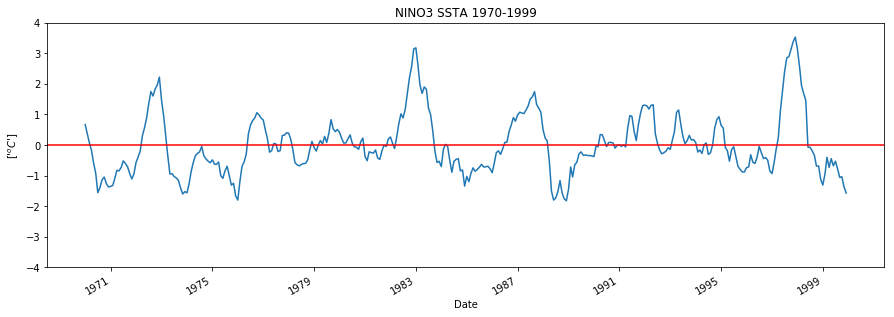

In [15]:
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1 , figsize=(15,5))
ax.plot(dates_n3, ssta_series)
ax.set_ylim((-4,4))

#horiz_line_data = np.array([0 for i in np.arange(len(dates_n3))])
#ax.plot(dates_n3, horiz_line_data, 'r--') 
ax.axhline(0, color='r')

ax.set_title('NINO3 SSTA 1970-1999')
ax.set_ylabel(['$^oC$'])
ax.set_xlabel('Date')

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y')

## 6. Save data

In [16]:
np.savez('data/ssta.nino3.30y.npz', ssta_series=ssta_series)

## References

http://unidata.github.io/netcdf4-python/

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.